In [36]:
%load_ext autoreload
%autoreload 2
import sys

import dgl
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
from IPython.display import Markdown, display
from karateclub.graph_embedding.graph2vec import Graph2Vec
from sklearn.linear_model import LogisticRegression
from tqdm.notebook import tqdm

sys.path.append("../")
from src.graph2vec import Ensemble_G2V, ExtendedGraph2Vec
from src.utils import *

plt.rcParams["figure.figsize"] = (16, 40)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Experiments for Github Stargazers dataset

In [37]:
dataset = CSL()

graphs, labels = [
    nx.Graph(dgl.to_networkx(dataset[it][0]).to_undirected())
    for it in range(len(dataset))
], dataset.graph_labels

order_dict = np.load("../datasets/CSL/orderings.npy", allow_pickle=True)[()]

[I] Preparing Circular Skip Link Graphs v4 ...
[I] Finished preparation after 0.5068s


### Parameters section

In [38]:
subset_card = len(graphs)  # number of graphs

cross_val_k = 15
    # number of folds to perform in cross-validation (could be int or LeaveOneOut())

In [39]:
MEASURES = ["closeness_centrality", "pagerank", "current_flow_closeness_centrality"]

tested_range = np.linspace(0, 1, 11)

WEIGHTING_FUNCTIONS = (
    {f"w_mean_{a:.2f}": ("w_mean",[a]) for a in tested_range}
    | {f"concat": ("concatenate",[])}
    | {f"p_proj_{a}": ("partial_projection",[0,a]) for a in (True,False)}
    | {f"w_proj_{a:.2f}": ("w_projection",[a]) for a in tested_range}
)

### Execution section

In [40]:
graphs_subset = graphs[:subset_card]

base_model = Graph2Vec()
without = ExtendedGraph2Vec()
with_dm = ExtendedGraph2Vec(use_pv_dm=True)
ens_model = Ensemble_G2V(without, with_dm)

### F1 score

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

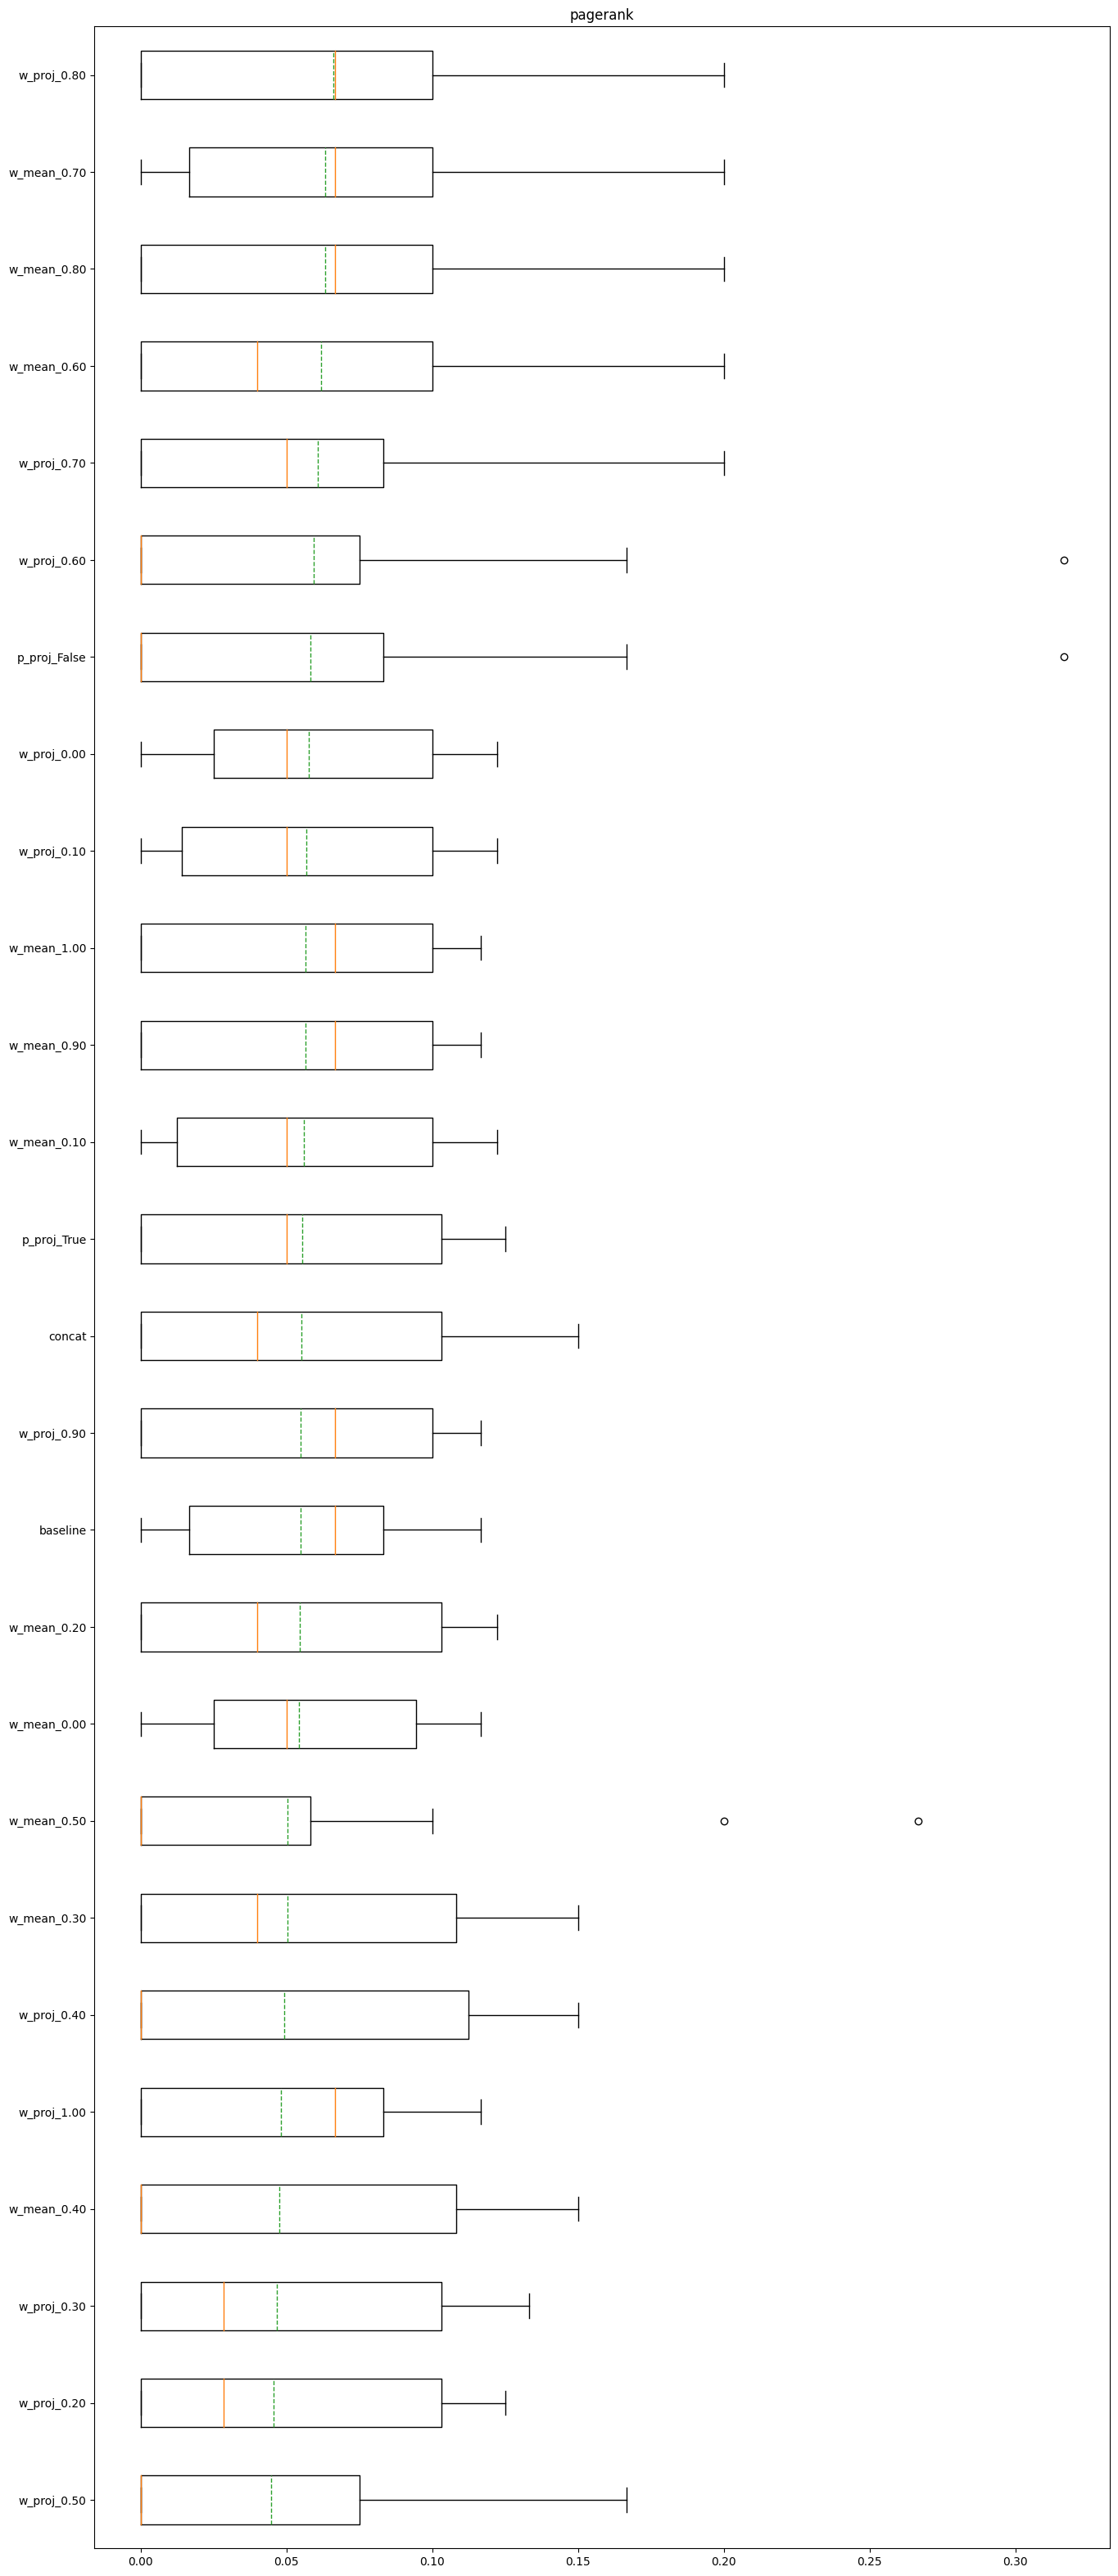

  0%|          | 0/25 [00:00<?, ?it/s]

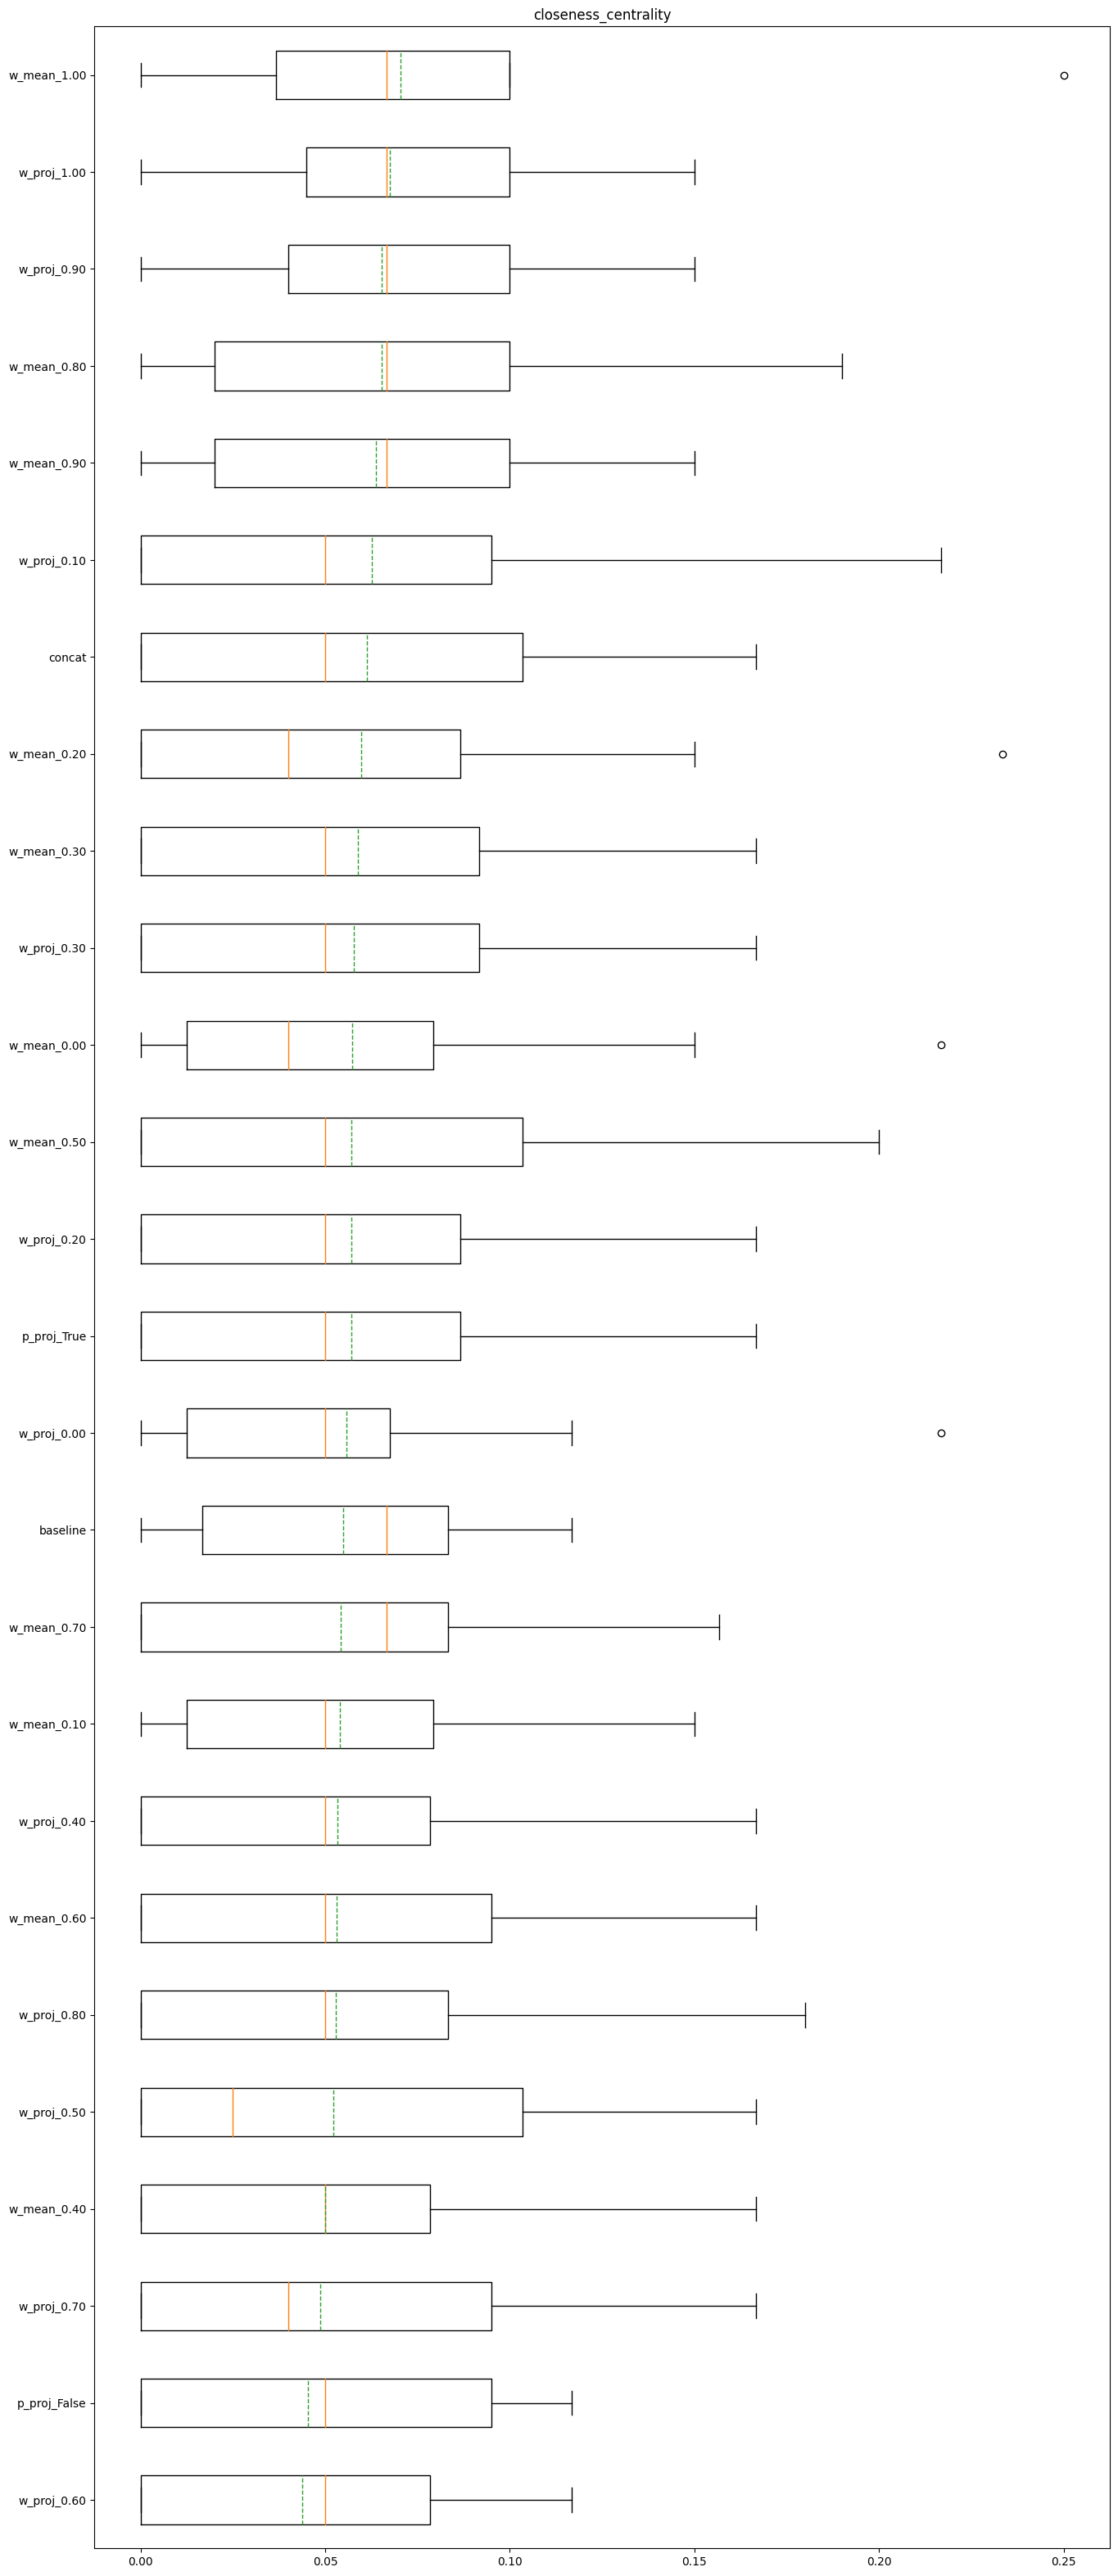

  0%|          | 0/25 [00:00<?, ?it/s]

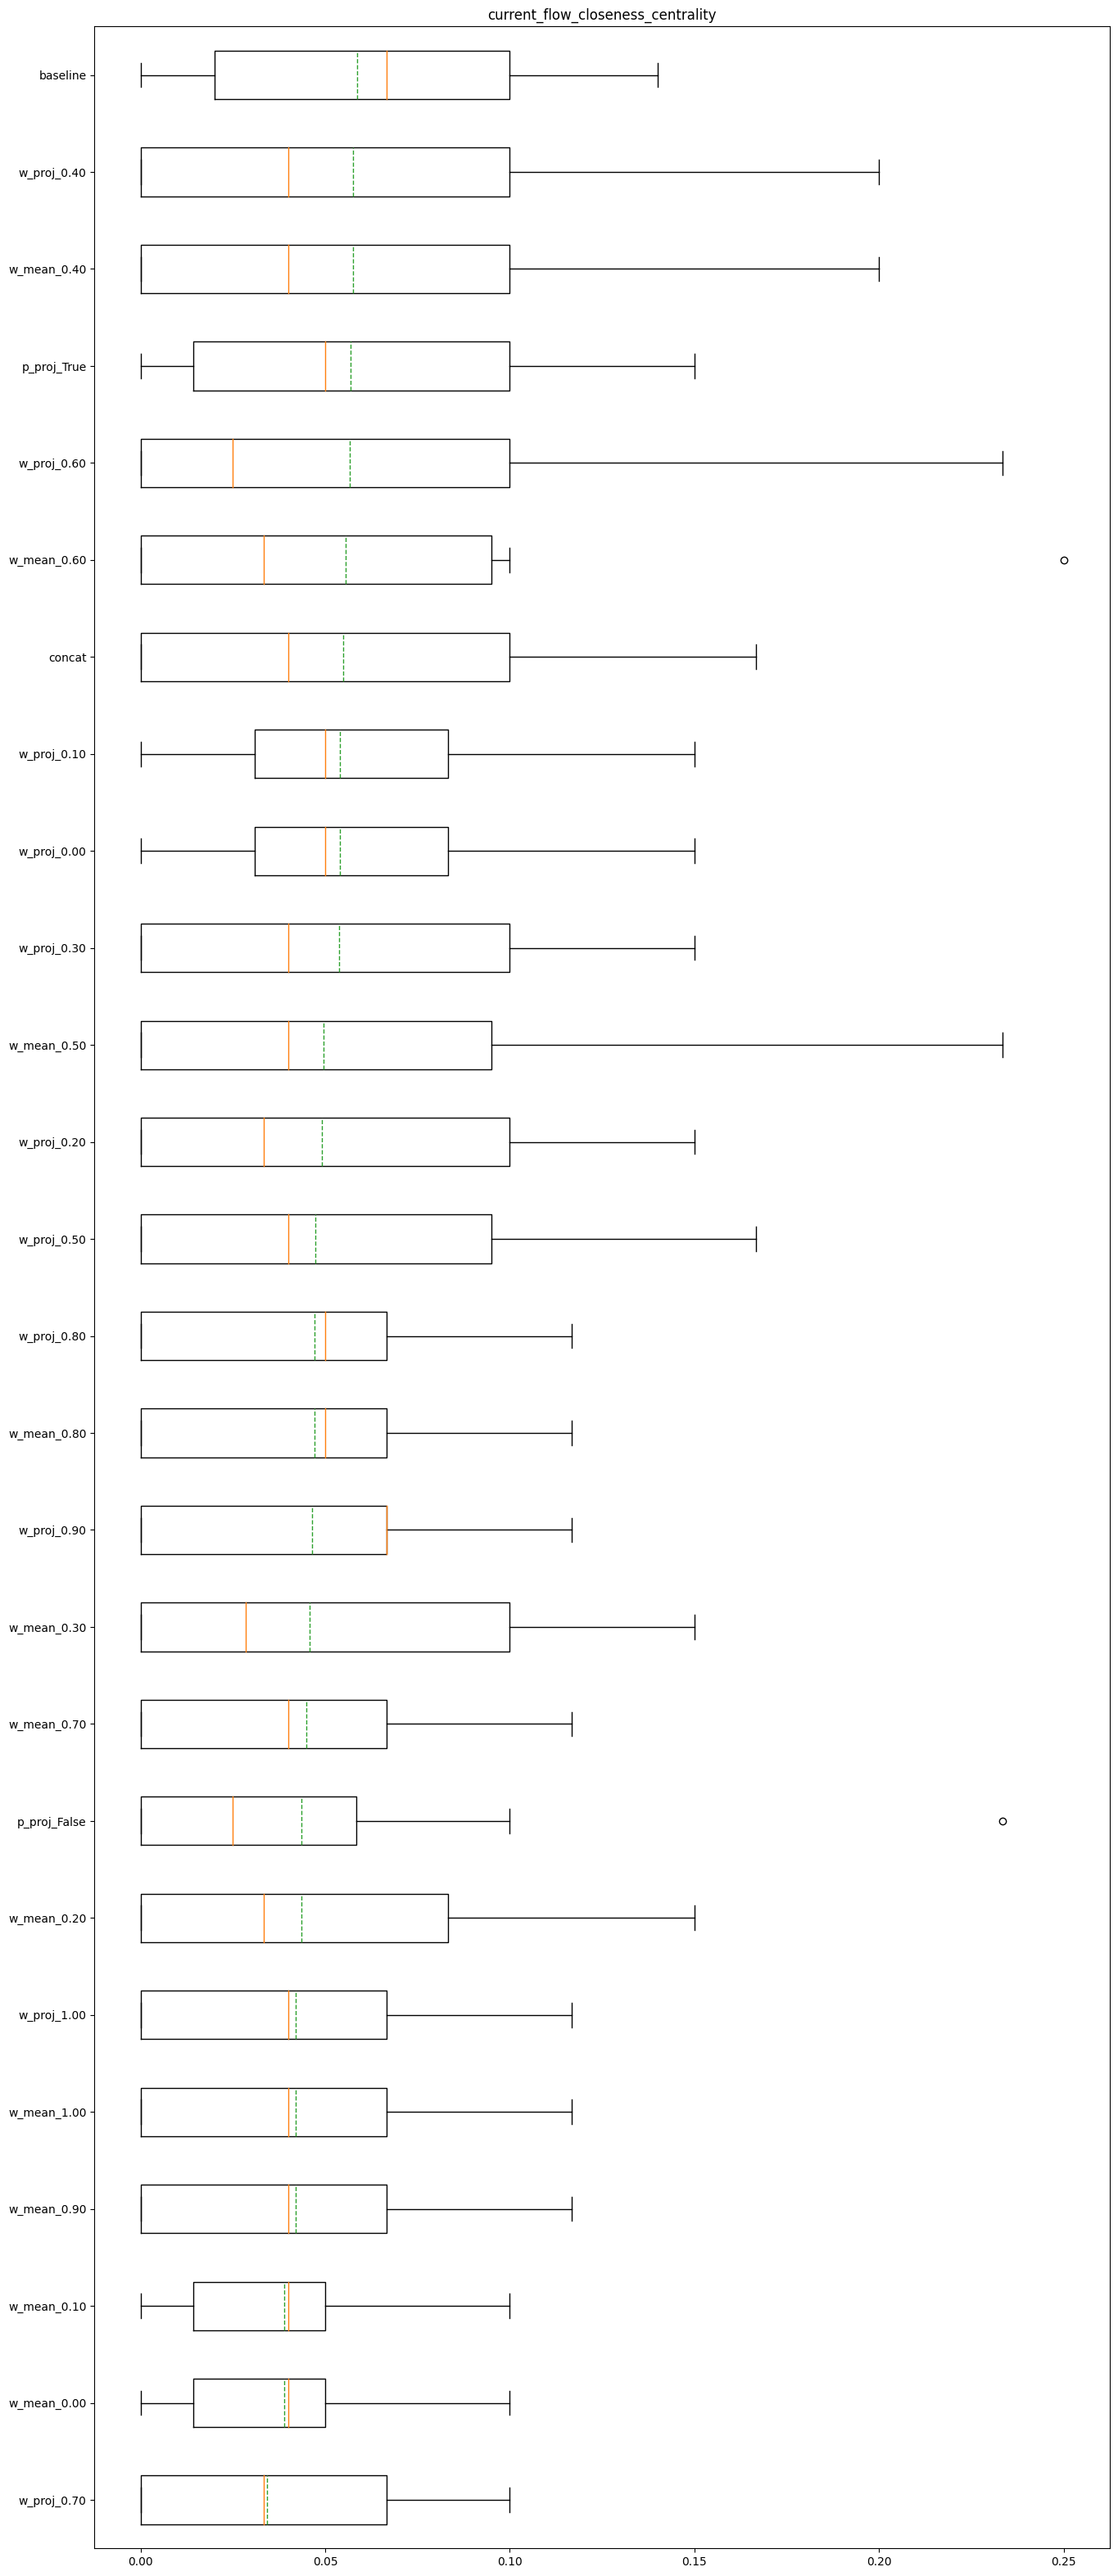

In [41]:
for measure, order in tqdm(order_dict.items()):
    base_model.fit(graphs_subset)
    res = {}
    ens_model.fit(graphs_subset, orderings=order)
    res["baseline"] = cross_validate(
    base_model.get_embedding(),
    labels,
    LogisticRegression(max_iter=1000),
    cv=cross_val_k,
    scoring="f1_macro",
)
    for name, (func,args) in tqdm(WEIGHTING_FUNCTIONS.items(), leave=False):
        ens_model.set_weighting_function(func,*args)
        res[name] = cross_validate(
            ens_model.get_embedding(),
            labels,
            LogisticRegression(max_iter=1000),
            cv=cross_val_k,
            scoring="f1_macro",

        )
    n_items = len(res)
    plt.title(measure)
    plt.boxplot(
        sorted(res.values(),key=lambda x:x.mean()),
        positions=range(n_items),
        vert=False,
        showmeans=True,
        meanline=True,
    )
    plt.yticks(range(n_items), labels=sorted(res.keys(),key=lambda x:res[x].mean()))
    plt.show()

### Accuracy

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

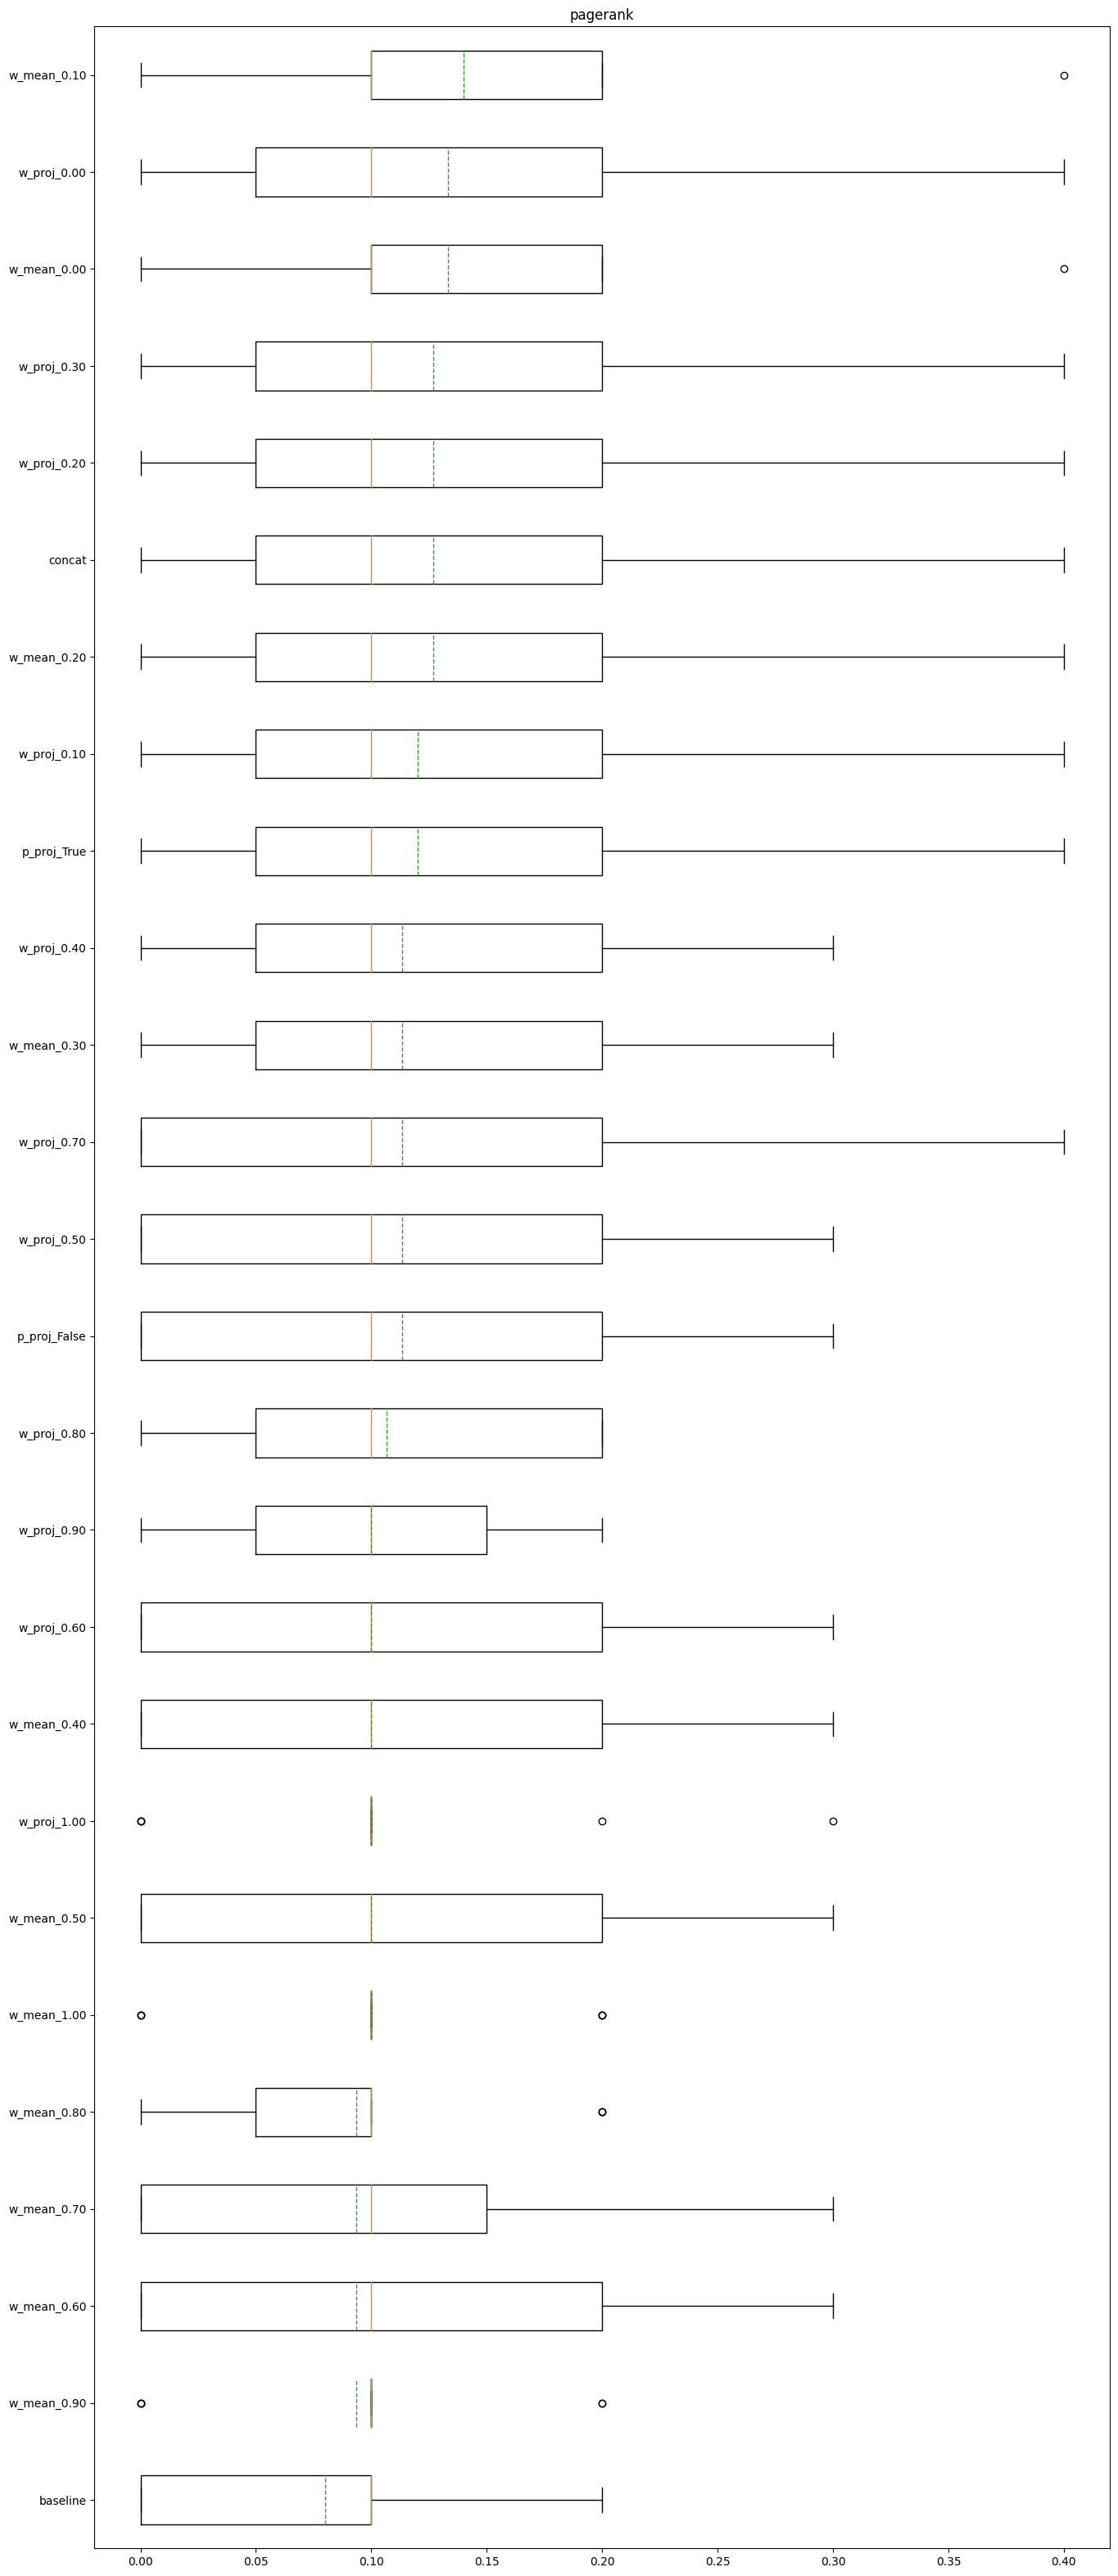

  0%|          | 0/25 [00:00<?, ?it/s]

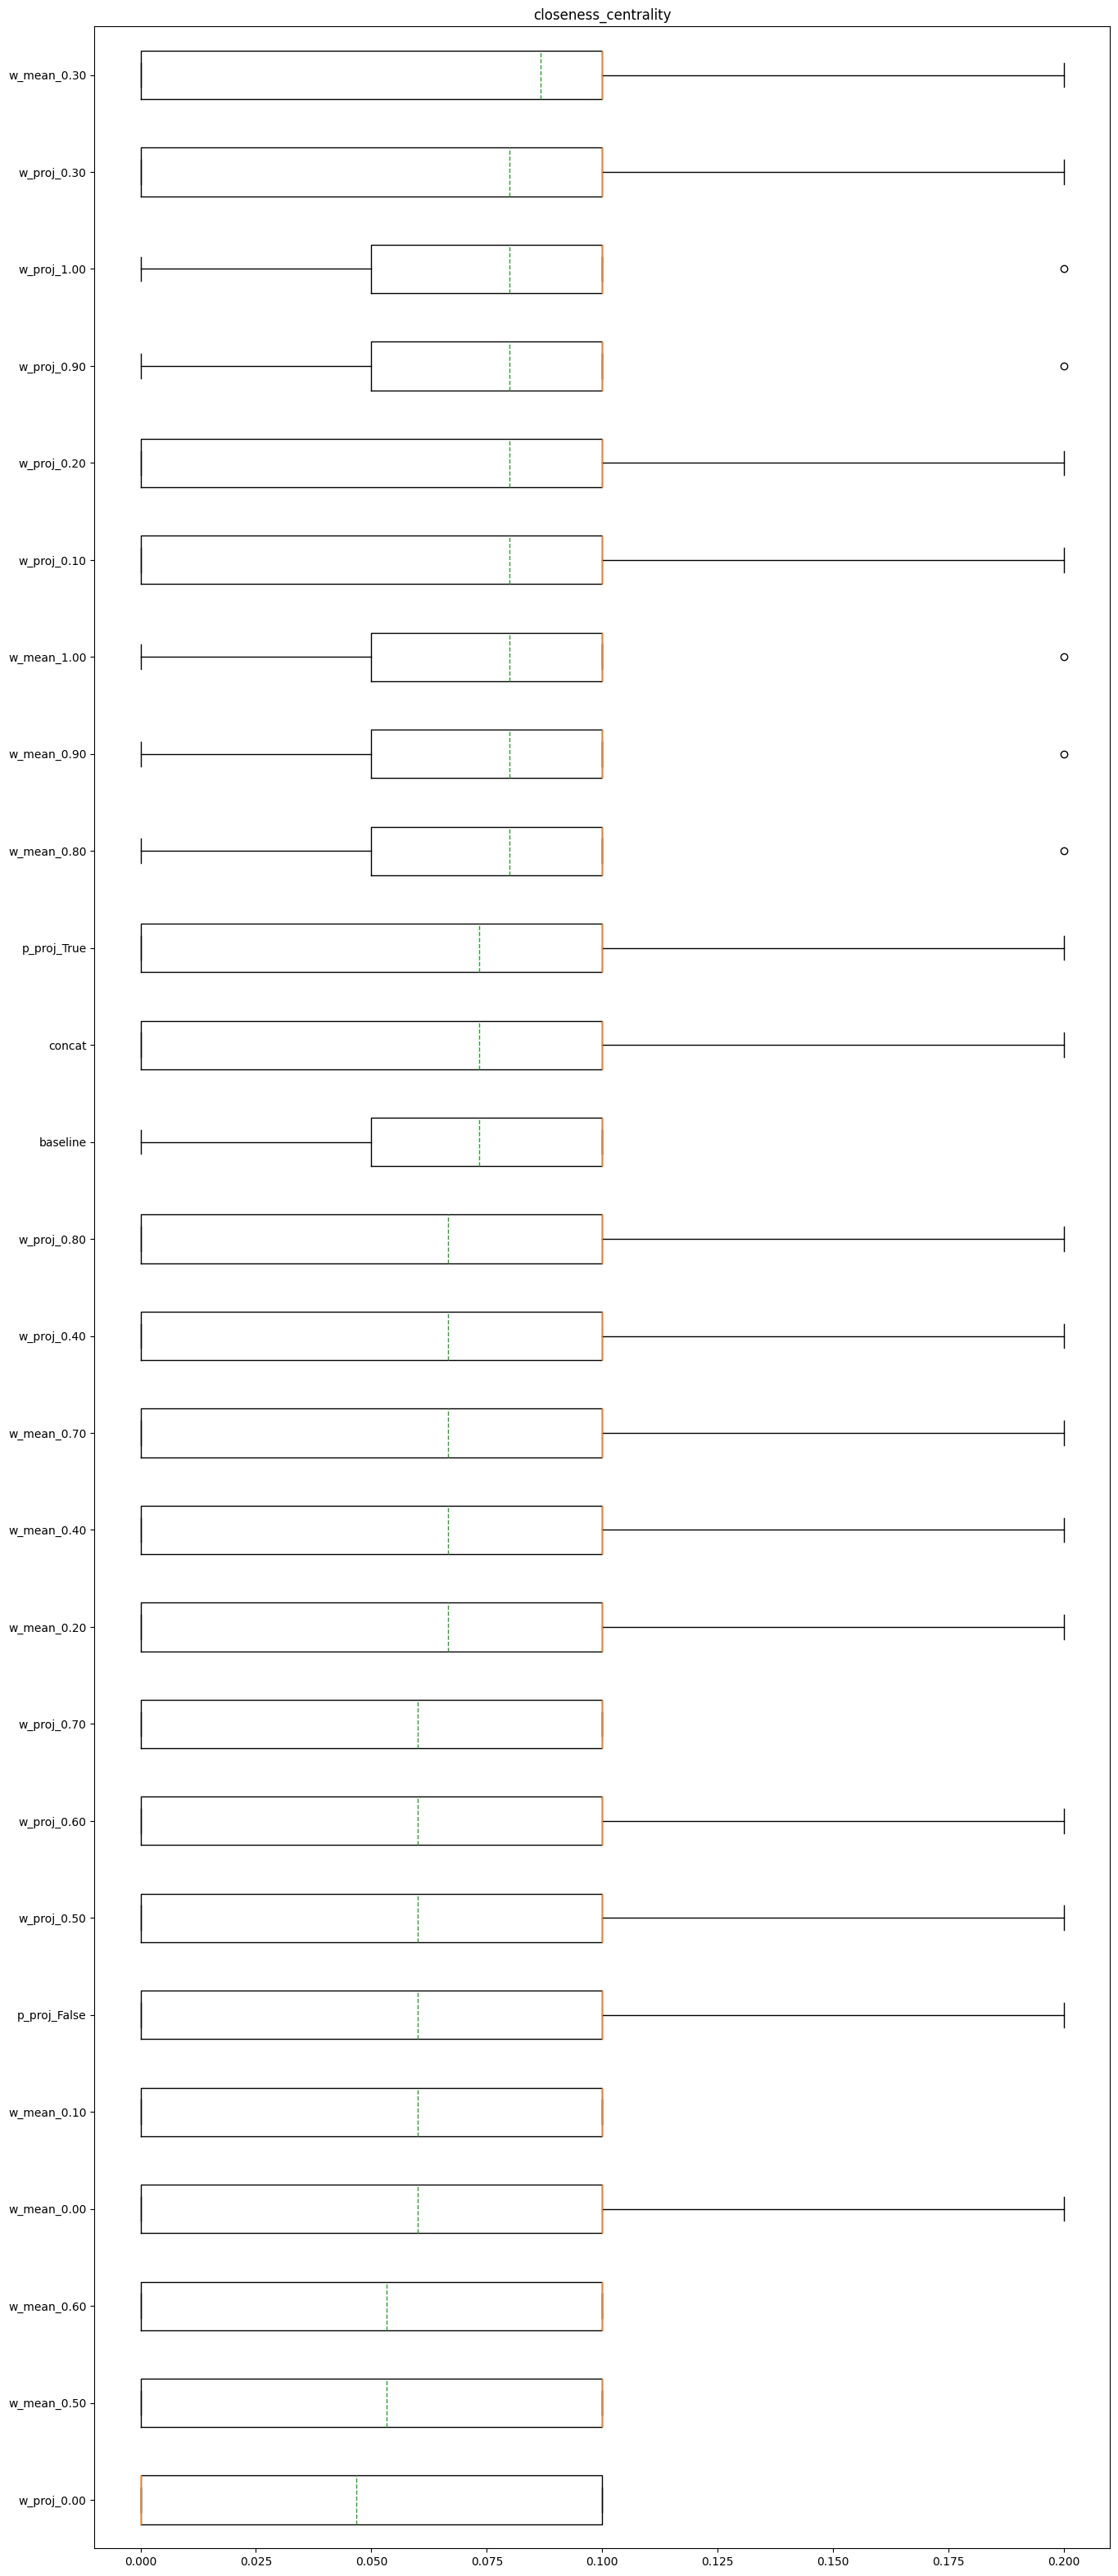

  0%|          | 0/25 [00:00<?, ?it/s]

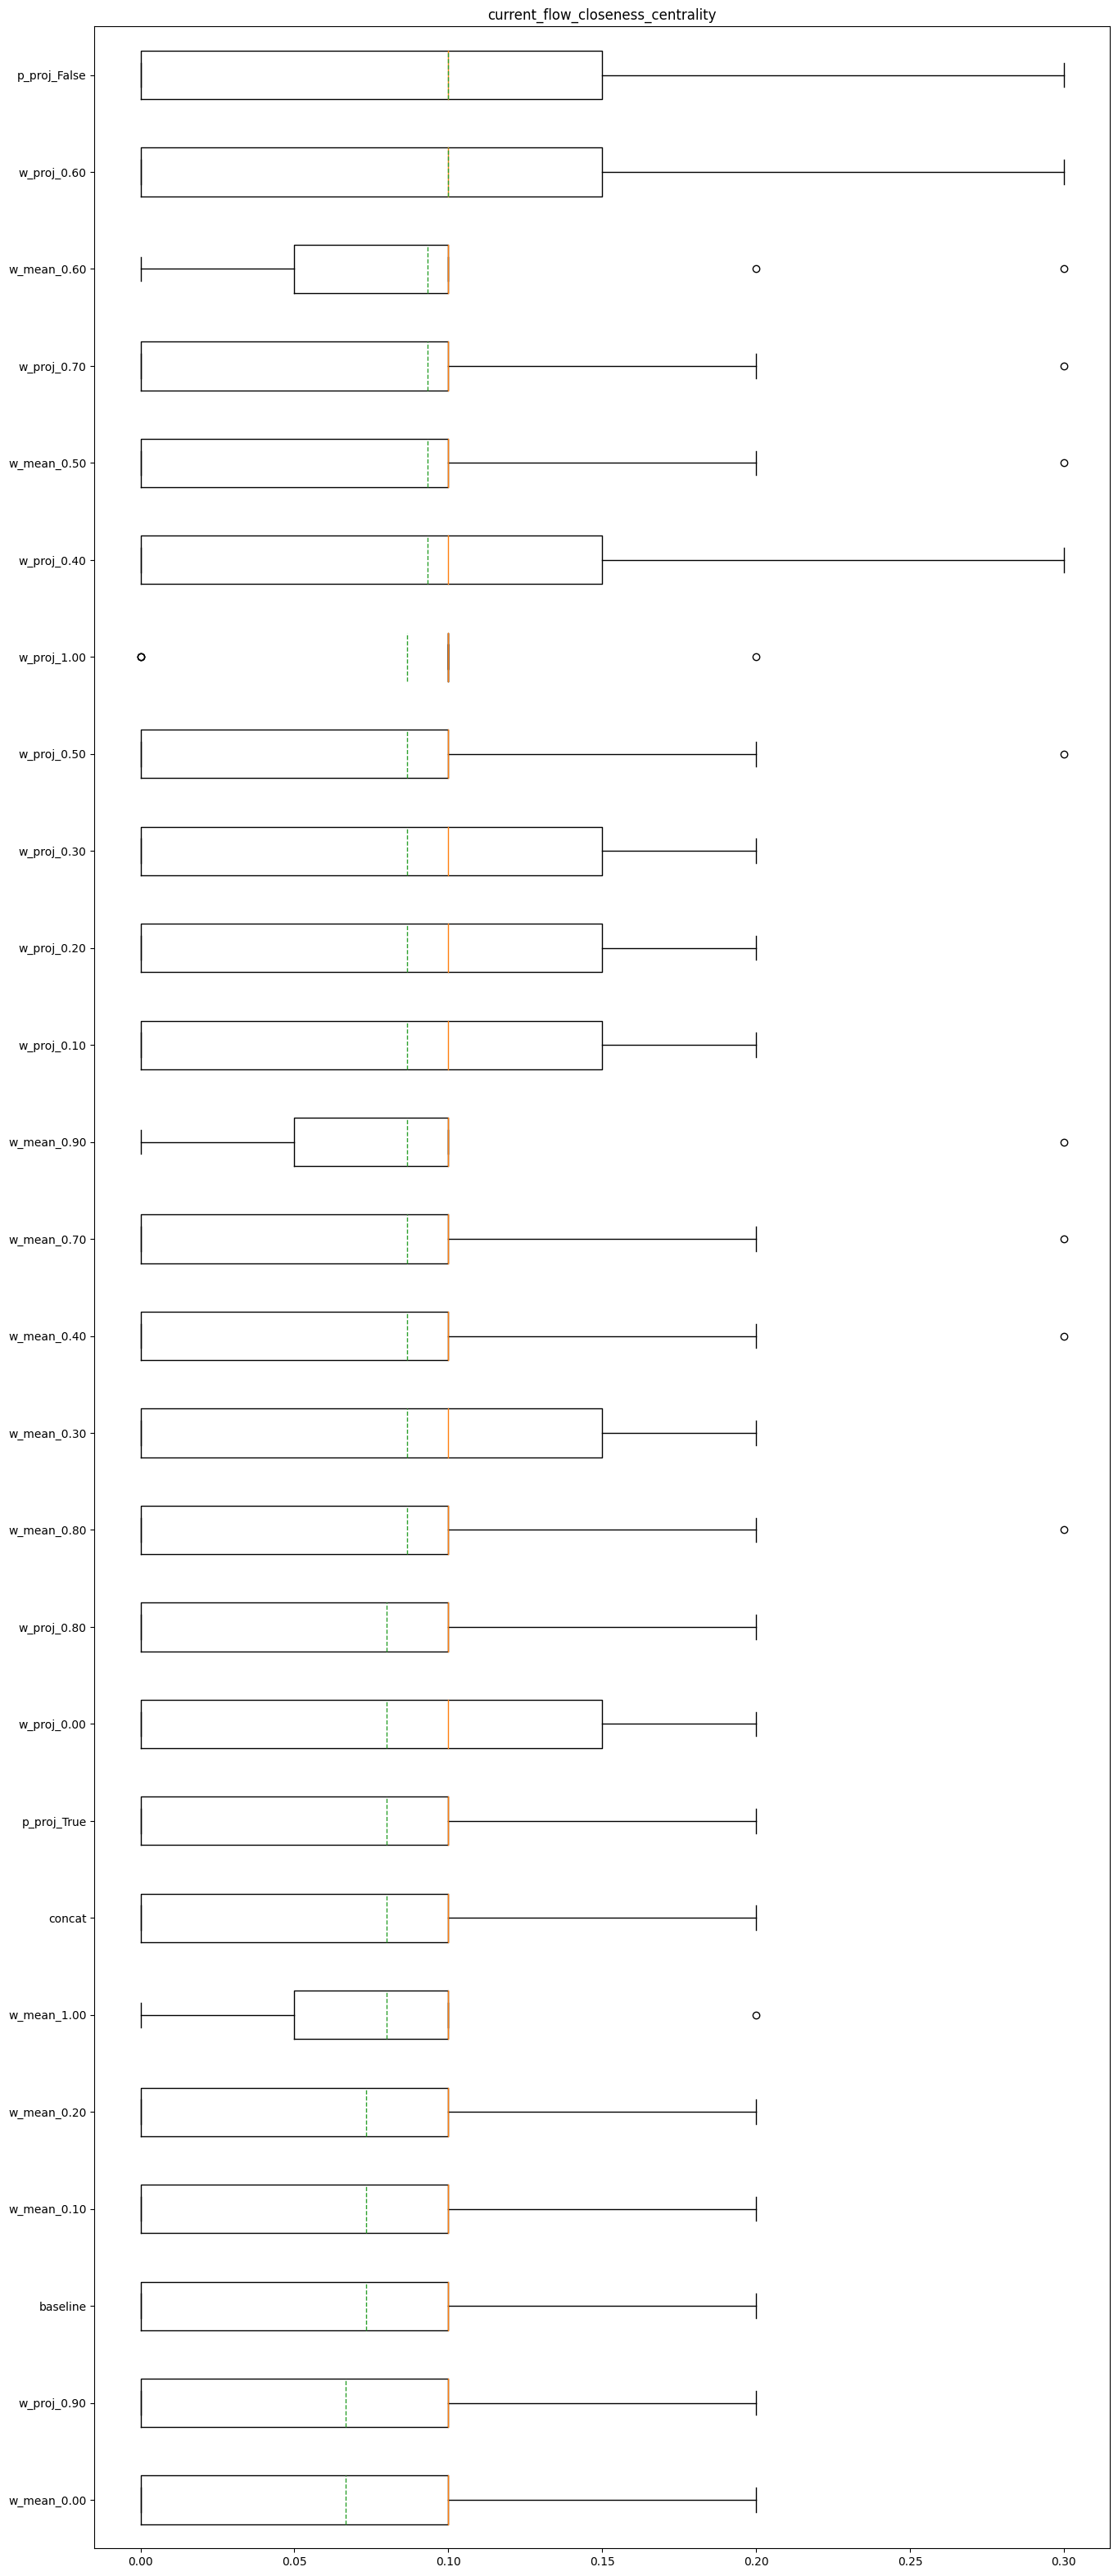

In [42]:
for measure, order in tqdm(order_dict.items()):
    base_model.fit(graphs_subset)
    res = {}
    ens_model.fit(graphs_subset, orderings=order)
    res["baseline"] = cross_validate(
    base_model.get_embedding(),
    labels,
    LogisticRegression(max_iter=1000),
    cv=cross_val_k,
    )
    for name, (func,args) in tqdm(WEIGHTING_FUNCTIONS.items(), leave=False):
        ens_model.set_weighting_function(func,*args)
        res[name] = cross_validate(
            ens_model.get_embedding(),
            labels,
            LogisticRegression(max_iter=1000),
            cv=cross_val_k,
        )
    n_items = len(res)
    plt.title(measure)
    plt.boxplot(
        sorted(res.values(),key=lambda x:x.mean()),
        positions=range(n_items),
        vert=False,
        showmeans=True,
        meanline=True,
    )
    plt.yticks(range(n_items), labels=sorted(res.keys(),key=lambda x:res[x].mean()))
    plt.show()